In [1]:
#imports
import os
import glob
import random
from scipy.io import loadmat
import numpy as np
import cv2

import keras
from tensorflow.keras.layers import (Input,Activation, Conv2D, Dropout, Convolution2D,UpSampling2D)
from tensorflow.keras.layers import (Activation, Conv3D, Dense, Dropout, Flatten,Conv2DTranspose,
                  Add,MaxPooling2D,MaxPooling3D, Input, Concatenate,BatchNormalization)
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.losses import mean_absolute_error
from tensorflow.keras.models import Sequential,load_model,Model
from tensorflow.keras.optimizers import Adam
import os, math
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf


Using TensorFlow backend.


In [11]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [2]:
driveroot=os.getcwd()

rgbdir=driveroot+"/NTIRE2020_Train_Clean"
hsdir=driveroot+"/NTIRE2020_Train_Spectral"

hpath=hsdir+'/ARAD_HS_*.mat'
rpath_clean=rgbdir+'/ARAD_HS_*_clean.png'
# print(rgbdir,hsdir,hpath,rpath_clean)

num_samples=450#number of files to load
image_size=128

hlist=glob.glob(hpath)[0:num_samples]
rgblist=glob.glob(rpath_clean)[0:num_samples]
print("number of hyperspectral imgs:",len(hlist))
print("number of rgb images:",len(rgblist))

number of hyperspectral imgs: 450
number of rgb images: 450


In [3]:
#validation sets
x_valdir=driveroot+"/NTIRE2020_Validation_Clean"
y_valdir=driveroot+"/NTIRE2020_Validation_Spectral"

In [4]:
Y_val=np.load(y_valdir+"/ntire2020_hs_validationset_10.npy")
X_val=np.load(x_valdir+"/ntire2020_rgbclean_validationset_10.npy")

In [5]:
# from skimage import img_as_ubyte
def normalize_data(data):
	# print("Normalizing Data ...........................")
	# print(data.shape, data.dtype, "min:",data.min(), "max:",data.max())
	temp = data
	data = temp/temp.max()
	return data	

def resize_npFile(data, image_size, file_save_path=None, save=False):	
#   print("Resizing the input data .................",data.shape)
  resize_np = np.zeros((data.shape[0],image_size, image_size, data.shape[3]))

  for j in range(data.shape[0]):
    for i in range(data.shape[3]):			
      # cv2.imwrite('org.png',img_as_ubyte(data[j][:,:,i]))
      temp = cv2.resize(data[j][:,:,i],(image_size, image_size), interpolation=cv2.INTER_AREA)	
      resize_np[j][:,:,i] = temp
      # print(data[j].shape, data[j][:,:,i].shape, temp.shape, resize_np[j].shape)			
  if save == True:
    np.save(file_save_path, resize_np)
    print('Successfully Saved .....', file_save_path, resize_np.shape)	
  return resize_np

In [6]:
#normalize
X_val=normalize_data(X_val)
Y_val=normalize_data(Y_val)

#resize
X_val=resize_npFile(X_val, image_size)
Y_val=resize_npFile(Y_val, image_size)

In [7]:
print("Validation set:",Y_val.shape, X_val.shape)

Validation set: (10, 128, 128, 31) (10, 128, 128, 3)


In [8]:
#load a batch of hyperspectral images
def load_batch_hyper(filelist):
    final_numpyData=np.array(0)
    for i in range(len(filelist)):
        x=loadmat(filelist[i])
        matimg=x['cube']
        final_numpyData=matimg if i==0 else np.stack([final_numpyData,matimg]) if i==1 else np.concatenate([final_numpyData,np.expand_dims(matimg, axis=0)])
    return final_numpyData

y=load_batch_hyper(hlist[5:10])
y.shape

(5, 482, 512, 31)

In [9]:
#load a batch of rgb images
def load_batch_rgb(filelist):
    final_numpyData=np.array(0)
    for i in range(len(filelist)):
        matimg = cv2.imread(filelist[i])
        final_numpyData=matimg if i==0 else np.stack([final_numpyData,matimg]) if i==1 else np.concatenate([final_numpyData,np.expand_dims(matimg, axis=0)])
    return final_numpyData
x=load_batch_rgb(rgblist[5:10])
x.shape

(5, 482, 512, 3)

In [10]:
def imageLoader(files_x,files_y, batch_size):
    L = len(files_x)
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            X = load_batch_rgb(files_x[batch_start:limit])
            Y = load_batch_hyper(files_y[batch_start:limit])

            #normalize
            X=normalize_data(X)
            Y=normalize_data(Y)

            #resize
            X=resize_npFile(X, image_size)
            Y=resize_npFile(Y, image_size)

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

In [11]:
def rgb2hs_autoenc(image_size):
	model = Sequential()
	model.add(Convolution2D(32, kernel_size=(3, 3),
	                        input_shape=(image_size,image_size,3)))
	model.add(Activation('relu'))
	model.add(Convolution2D(64, kernel_size=(3, 3)))
	model.add(Activation('relu'))
	# model.add(Dropout(0.25))
	model.add(Convolution2D(64, kernel_size=(3, 3)))
	model.add(Activation('relu'))
	model.add(Convolution2D(64, kernel_size=(3, 3)))
	model.add(Activation('relu'))
	# model.add(Dropout(0.25))

	model.add(Convolution2D(64, kernel_size=(3, 3)))
	model.add(Activation('relu'))

	model.add(Conv2DTranspose(64,kernel_size=(3,3)))
	model.add(Activation('relu'))
	model.add(Conv2DTranspose(64,kernel_size=(3,3)))
	model.add(Activation('relu'))
	model.add(Conv2DTranspose(64,kernel_size=(3,3)))
	model.add(Activation('relu'))
	model.add(Conv2DTranspose(64,kernel_size=(3,3)))
	model.add(Activation('relu'))
	model.add(Conv2DTranspose(31,kernel_size=(3,3)))
	model.add(Activation('relu'))

	return model

In [12]:
#model params
epochs=5
batch_size=8
lr=0.0001

initial_epoch=0

image_size=128

model_save_dir=driveroot+"/models"
model_name="conv_autoencoder_5_loc"
version=1

In [13]:
model=rgb2hs_autoenc(image_size)    
model.compile(loss='mean_absolute_error', optimizer=Adam(lr=lr), metrics=['mae','mse'])
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_save_dir+'/model_'+str(model_name)+'_'+str(version)+'_'+str(epochs)+'.h5',
                                             monitor='loss',verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=50)
csv_logger = tf.keras.callbacks.CSVLogger(model_save_dir + "/tr_-v"+str(version)+".csv", separator=',', append=True)
history=model.fit(imageLoader(rgblist,hlist,batch_size), validation_data=(X_val, Y_val), steps_per_epoch=math.ceil(num_samples/batch_size), epochs=epochs,verbose=1,callbacks=[checkpoint, csv_logger], shuffle=True)

# history = model.fit(x=X_data, y=Y_data, batch_size=batch_size, epochs=epochs, verbose=1, initial_epoch=initial_epoch,
 					# validation_split=0.2,callbacks=[checkpoint, csv_logger], shuffle=False)
# history = model.fit(x=X_data, y=Y_data, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.2, 
                            # validation_data=(X_val, Y_val), shuffle=True)

Epoch 1/5
57/57 [==============================] - 587s 10s/step - mae: 0.1130 - loss: 0.1130 - mse: 0.0336 - val_loss: 0.1008 - val_mae: 0.1008 - val_mse: 0.0254
Epoch 2/5
57/57 [==============================] - 580s 10s/step - mae: 0.0654 - loss: 0.0654 - mse: 0.0134 - val_loss: 0.0687 - val_mae: 0.0687 - val_mse: 0.0131
Epoch 3/5
57/57 [==============================] - 522s 9s/step - mae: 0.0516 - loss: 0.0516 - mse: 0.0083 - val_loss: 0.0619 - val_mae: 0.0619 - val_mse: 0.0110
Epoch 4/5
57/57 [==============================] - 469s 8s/step - mae: 0.0463 - loss: 0.0463 - mse: 0.0066 - val_loss: 0.0543 - val_mae: 0.0543 - val_mse: 0.0085
Epoch 5/5
57/57 [==============================] - 506s 9s/step - mae: 0.0365 - loss: 0.0365 - mse: 0.0044 - val_loss: 0.0437 - val_mae: 0.0437 - val_mse: 0.0049


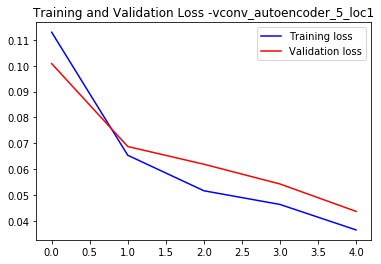

In [14]:
import matplotlib
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], 'b', label='Training loss')
plt.plot(history.history['val_loss'], 'r', label='Validation loss')
plt.title('Training and Validation Loss -v'+str(model_name)+str(version))
plt.legend()
plt.savefig(os.path.join(model_save_dir, str(model_name)+'_train_loss_'+str(version)+'_'+str(epochs)+'.png')) 
# plt.show()

In [16]:
model_json = model.to_json()
with open(model_save_dir+'/model_'+str(model_name)+'_'+str(version)+'_'+str(epochs)+'.json', "w+") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(model_save_dir+'/model_'+str(model_name)+'_'+str(version)+'_'+str(epochs)+'.h5')
print("Saved model to disk")

Saved model to disk


In [17]:
sample_x,sample_y=X_val[0],Y_val[0]
y_pred=model.predict(np.expand_dims(sample_x,axis=0))
# y_pred.shape
rmaee=abs(sample_y-y_pred[0])/sample_y
rmaee.shape

(128, 128, 31)

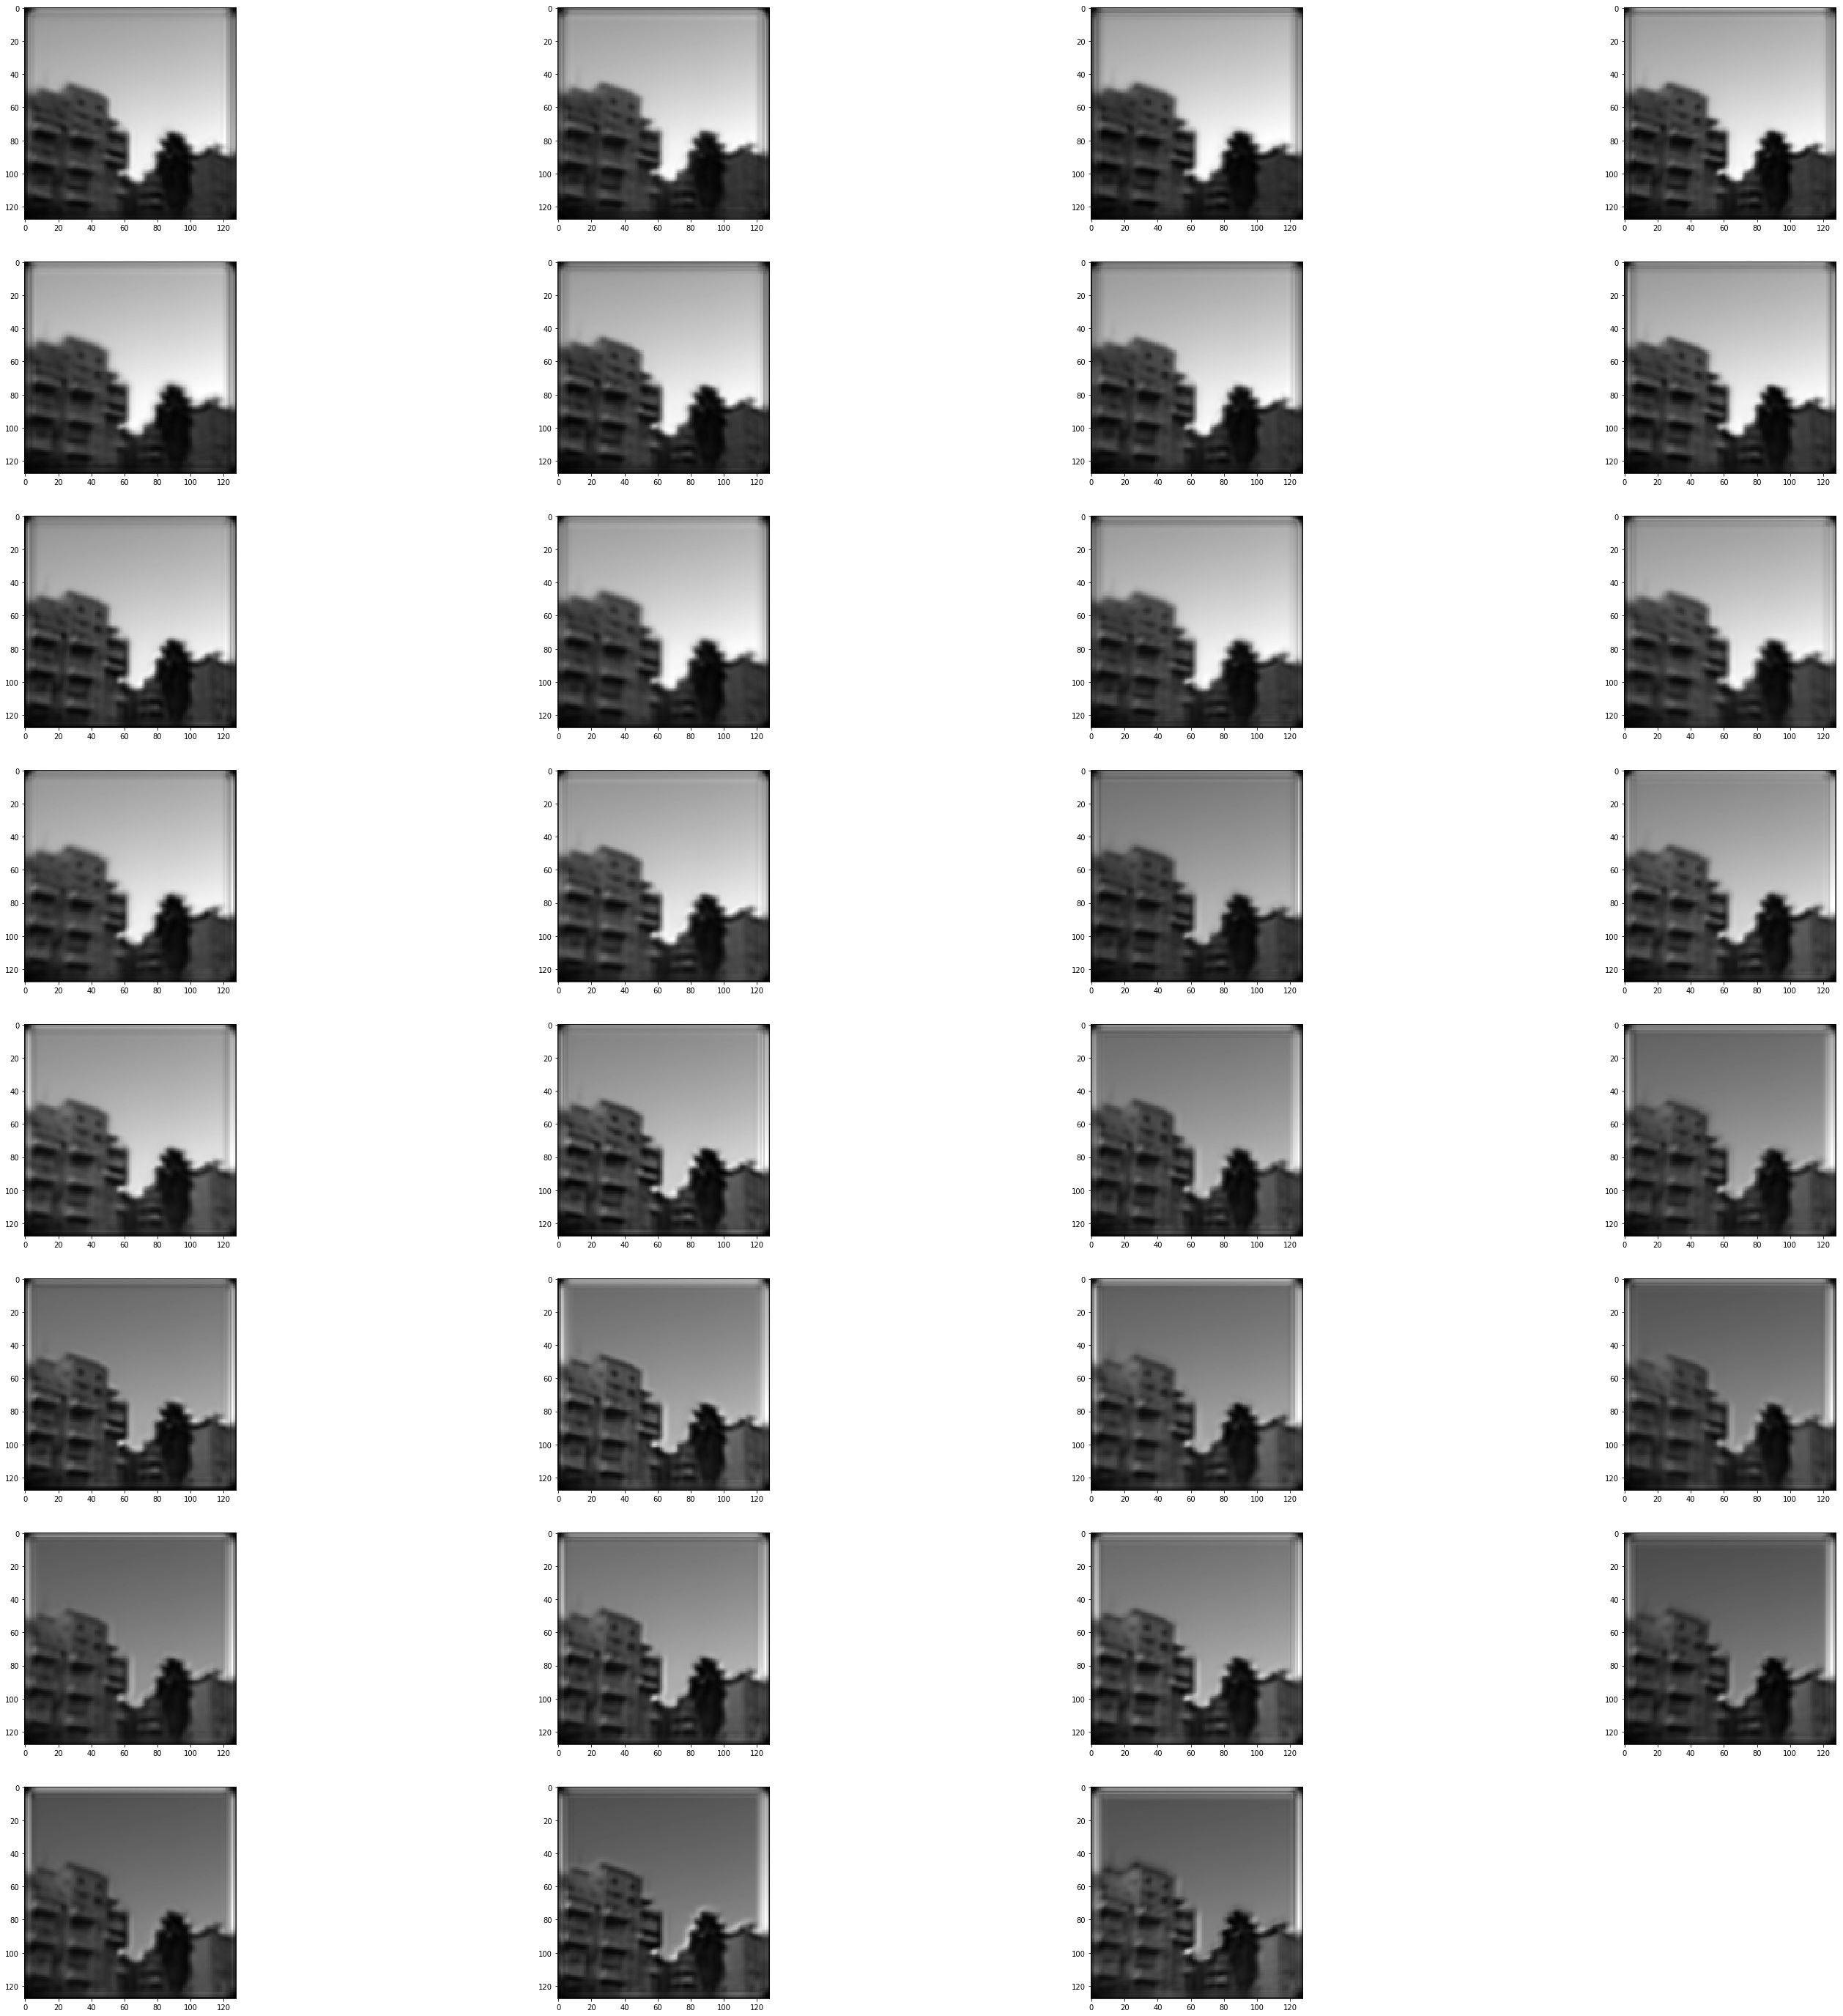

In [19]:
#plotting model output
g=plt.figure(figsize=(50, 50))
for i in range(31):
    plt.subplot(8,4,i+1)
    plt.imshow(y_pred[0,:,:,i],cmap='gray')

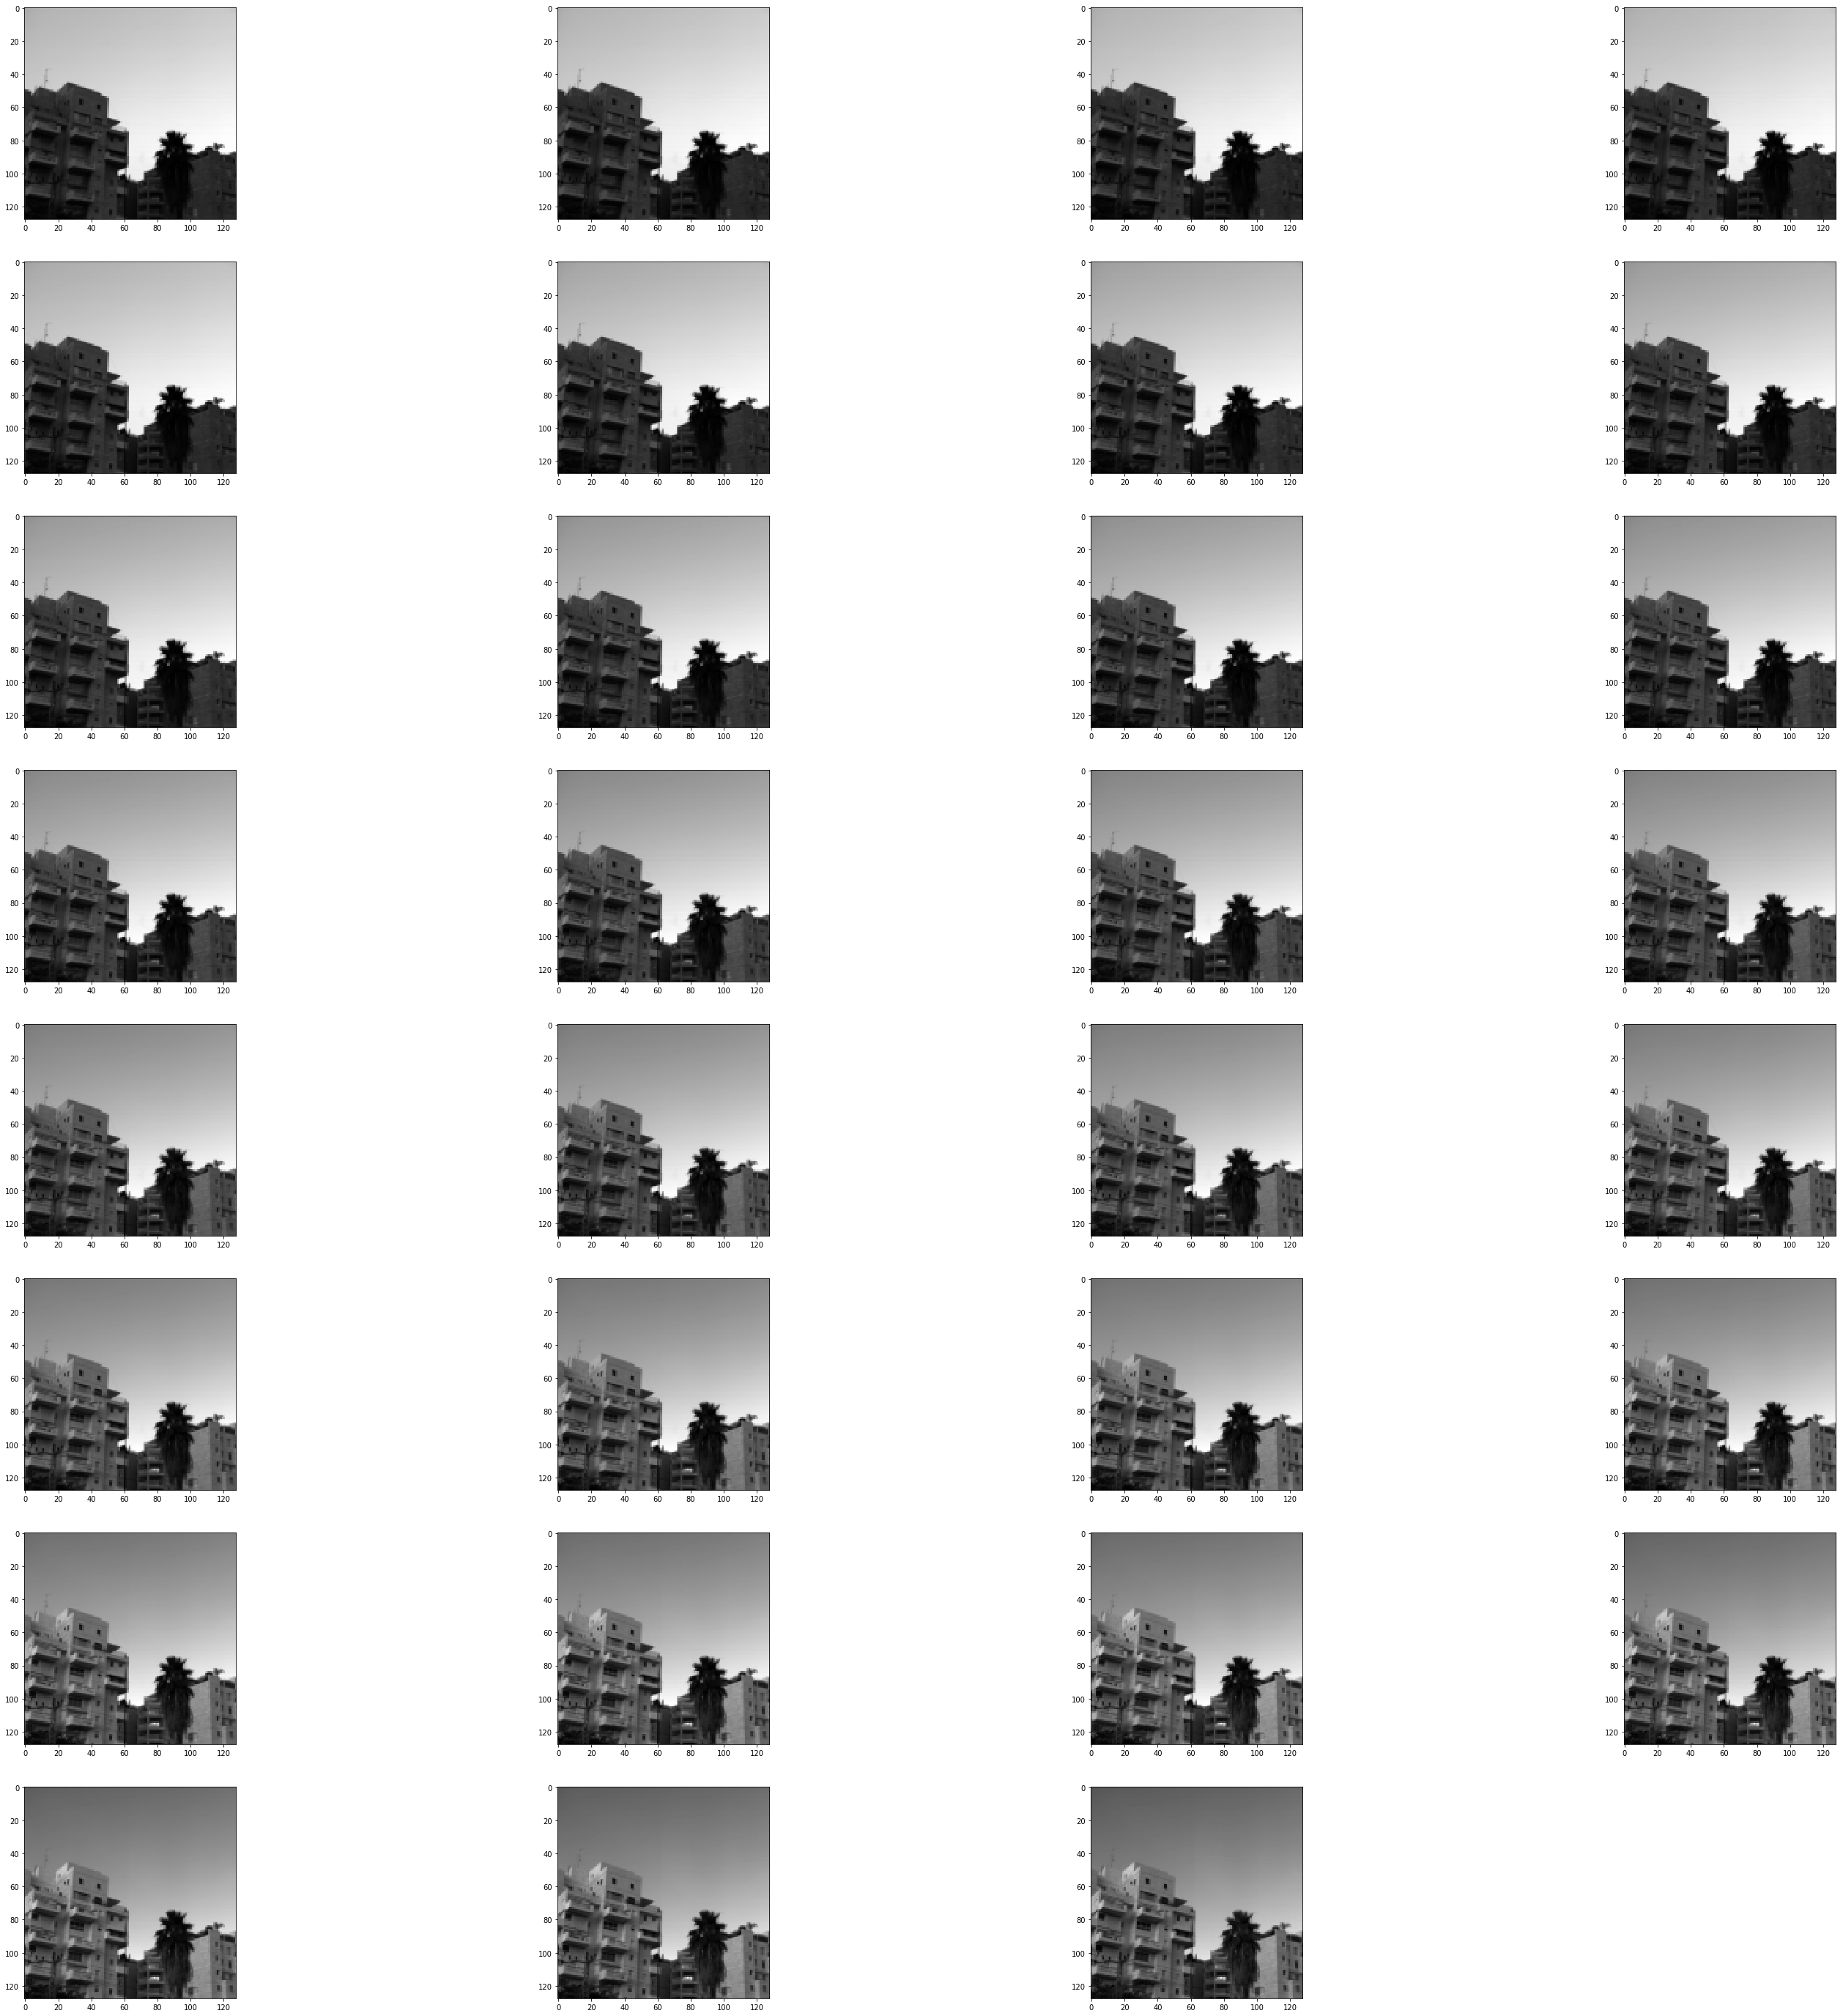

In [20]:
#plotting ground truth
g=plt.figure(figsize=(50, 50))
for i in range(31):
    plt.subplot(8,4,i+1)
    plt.imshow(sample_y[:,:,i],cmap='gray')

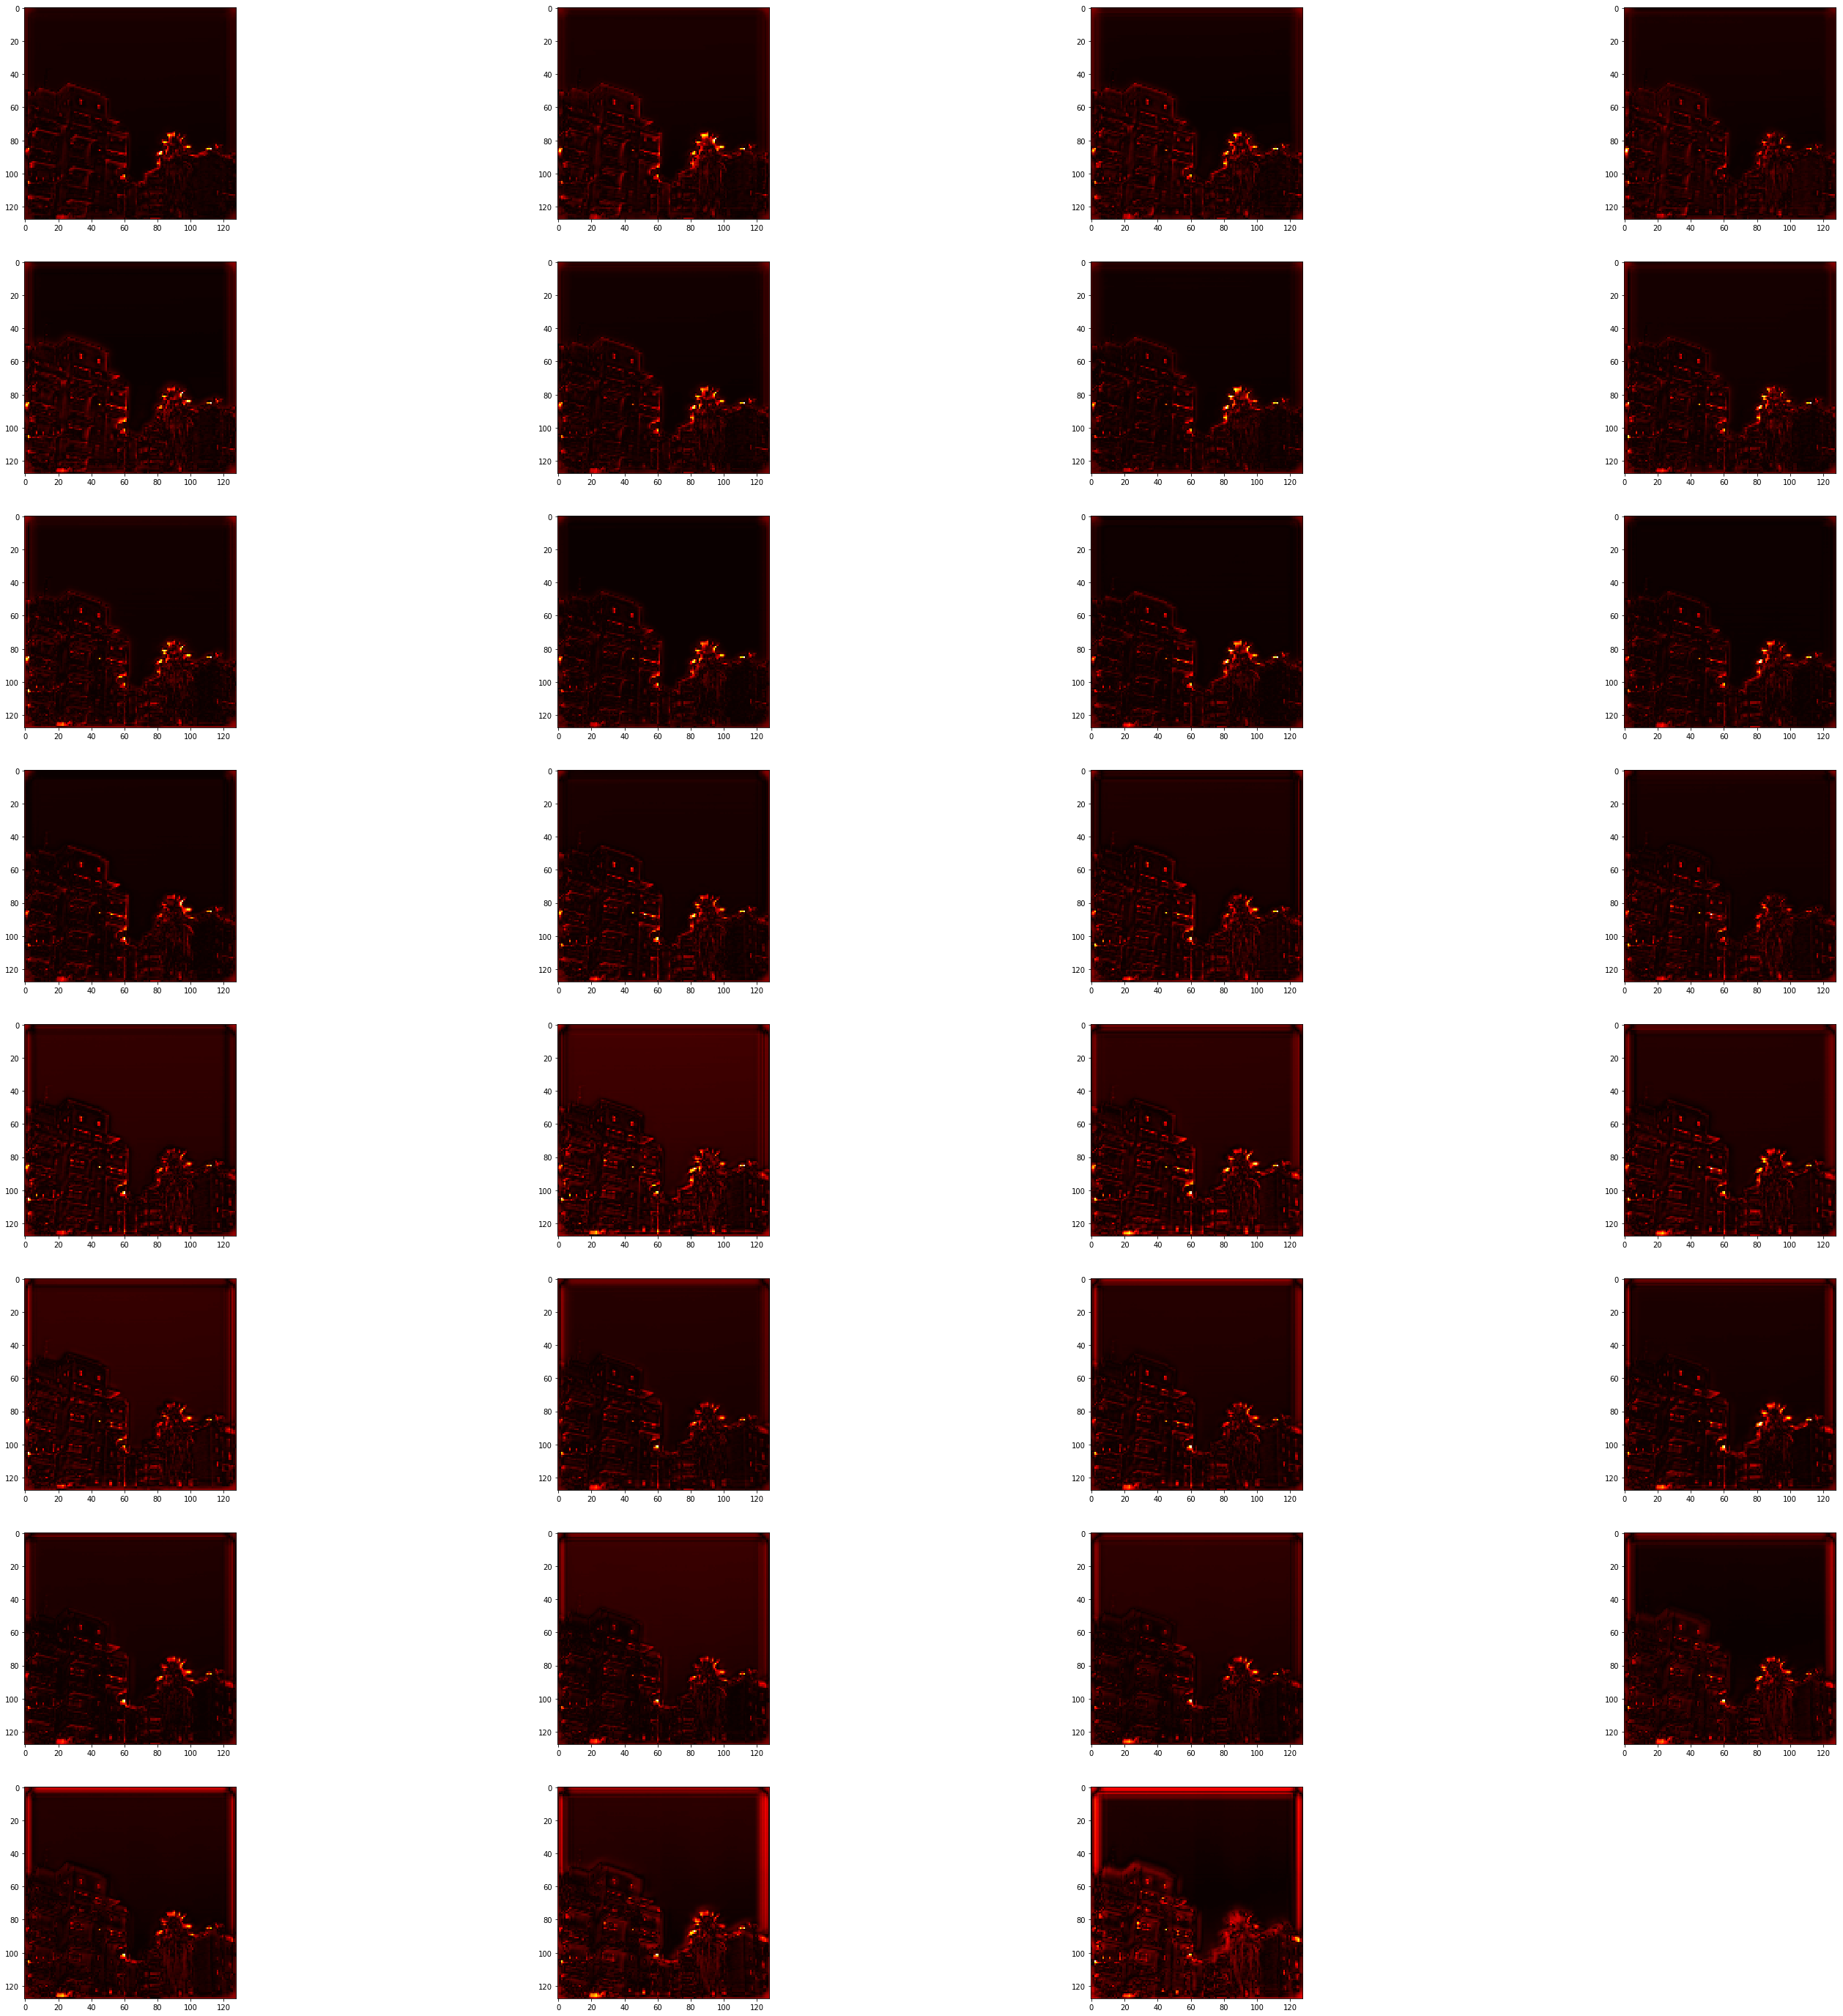

In [18]:
#plotting error maps
f=plt.figure(figsize=(50, 50))
for i in range(31):
    plt.subplot(8,4,i+1)
    plt.imshow(rmaee[:,:,i],cmap=plt.get_cmap('hot'), interpolation='nearest')
# plt.show()